In [1]:
%matplotlib inline
import nrrd
import nibabel as nib
import numpy as np
import pandas as pd
import re
import pydicom as dicom
from matplotlib import pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from scipy import ndimage
import SimpleITK as sitk
import gdcm
#print("Hello")

In [15]:
def getSubPaths(dir):
    list = []
    # 判断路径是否存在
    if (os.path.exists(dir)):
        # 获取该目录下的所有文件或文件夹目录
        files = os.listdir(dir)
        for file in files:
            # 得到该文件下所有目录的路径
            m = os.path.join(dir, file)
            # 判断该路径下是否是文件夹
            if (os.path.isdir(m)):
                h = os.path.split(m)
                list.append(m)
    return list

In [16]:
def SZ_data_path(data_path_SZ):  #获取sz的治疗前后的数据地址
    assert os.path.exists(data_path_SZ), data_path_SZ + ' : path does not exist !'
    subpath_patient = getSubPaths(data_path_SZ)  # SZ
    # print("1111111111111111",subpath_patient)
    subpath_patient.sort(key=lambda x: int(re.split('SZ|_', x)[1]))
    # print("2222222222222222",subpath_patient)
    t1_path = []  # 治疗前的数据的地址
    t2_path = []  # 治疗后的数据的地址
    for i in range(len(subpath_patient)):
        middle_path = getSubPaths(subpath_patient[i])
        t1 = middle_path[0]
        t2 = middle_path[1]
        # print(t1,t2)
        if (os.path.isdir(os.path.join(t1, os.listdir(t1)[0]))):  # 如果下面还有一层文件
            t1_dir = os.listdir(t1)  # t1时期的文件夹，里面是两个ct的文件
            path1 = os.path.join(t1, t1_dir[0])
            path2 = os.path.join(t1, t1_dir[1])
            t1 = [path1 if "ct_roi.nrrd" in os.listdir(path1) else path2]
            t1_path.append(t1)
            # t2_path.append(t2)
        else: t1_path.append([t1])
        if (os.path.isdir(os.path.join(t2, os.listdir(t2)[1]))):  # 如果下面还有一层文件
            t2_dir = os.listdir(t2)  # t2时期的文件夹，里面是两个ct的文件
            path1 = os.path.join(t2, t2_dir[0])
            path2 = os.path.join(t2, t2_dir[1])
            t2 = [path1 if "ct_roi.nrrd" in os.listdir(path1) else path2]
            t2_path.append(t2)
        else:t2_path.append([t2])
        # t1_path.append(t1)
        # t2_path.append(t2)
    assert len(t1_path) == len(t2_path), "治疗前后的数据长度不同"
    return t1_path,t2_path

def ZZ_data_path(data_path_ZZ):  #获取zz的治疗前后的数据地址
    assert os.path.exists(data_path_ZZ), data_path_ZZ + ' : path does not exist !'
    subpath_patient = getSubPaths(data_path_ZZ)  # SZ
    # print("1111111111111111",subpath_patient)
    subpath_patient.sort(key=lambda x: int(re.split('ZZ|_', x)[1]))
    # print("2222222222222222",subpath_patient)
    t1_path = []  # 治疗前的数据的地址
    t2_path = []  # 治疗后的数据的地址
    for i in range(len(subpath_patient)-1):
        middle_path = getSubPaths(subpath_patient[i])
        t1 = middle_path[0]
        t2 = middle_path[1]
        # print(t1,t2)
        # print("t1:",os.listdir(t1))
        t1_mid_path = os.listdir(t1)
        t1_mid_path = [word for word in t1_mid_path if 'rar' not in word]
        t2_mid_path = os.listdir(t2)
        t2_mid_path = [word for word in t2_mid_path if 'rar' not in word]
        # print(t1)
        # print(t1_mid_path)
        if (os.path.isdir(t1)):  # 如果下面还有一层文件
            # t1_dir = os.listdir(t1)  # t1时期的文件夹，里面是两个ct的文件
            path1 = os.path.join(t1, t1_mid_path[0])
            path2 = os.path.join(t1, t1_mid_path[1])
            t1 = [path1 if "ct_roi.nrrd" in os.listdir(path1) else path2]
        if (os.path.isdir(t2)):  # 如果下面还有一层文件
            # t2_dir = os.listdir(t2)  # t2时期的文件夹，里面是两个ct的文件
            path1 = os.path.join(t2, t2_mid_path[0])
            path2 = os.path.join(t2, t2_mid_path[1])
            t2 = [path1 if "ct_roi.nrrd" in os.listdir(path1) else path2]
        t1_path.append(t1)
        t2_path.append(t2)
    assert len(t1_path) == len(t2_path), "治疗前后的数据长度不同"
    return t1_path,t2_path

In [4]:
""" data_path_SZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou"
data_path_ZZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong"
t1_path,t2_path = SZ_data_path(data_path_SZ)  #shantou的ct原始数据地址
t1_path , t2_path """

' data_path_SZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou"\ndata_path_ZZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong"\nt1_path,t2_path = SZ_data_path(data_path_SZ)  #shantou的ct原始数据地址\nt1_path , t2_path '

In [5]:
""" pre_path = t1_path[1]
post_path = t2_path[1]
seg_path = [word for word  in os.listdir(pre_path[0]) if '_T.nii.gz' in word]
pre_path , post_path
seg_path = os.path.join(pre_path[0],seg_path[0])
seg_path """

" pre_path = t1_path[1]\npost_path = t2_path[1]\nseg_path = [word for word  in os.listdir(pre_path[0]) if '_T.nii.gz' in word]\npre_path , post_path\nseg_path = os.path.join(pre_path[0],seg_path[0])\nseg_path "

In [17]:
def get_pixels_hu(slices):  #输入是dim的numpy，处理成hu之后返回  （Z , X, Y）
    #print(slices[0].pixel_array)
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        #print(intercept)
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def load_scan(path):  #path是dcm文件所在的文件夹。返回没有堆叠的dcm的numpy  （Z , X, Y）
    path = path[0]
    data_list = os.listdir(path)  #80B--》97B
    img_list = []
    data_list_temp = []
    for data in data_list:
        if '.nrrd' not in data and 'nii.gz' not in data and 'nii' not in data:
            data_list_temp.append(data)
    data_list = data_list_temp

    slices = [dicom.read_file(path + '/' + s) for s in data_list]
                    #对一个病人的所有slices进行排序，x指的是一个slice。slice里面有好多属性，
                    #有一个是ImagePositionPatient.按照他的这个属性进行对这些slices排序，方便我们组三维rendering。
                    #imageOrientationPatient表示的是当前图像的第一行在空间中的三维方向向量与第一列的三维方向向量。
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    """ print(slices[0].ImagePositionPatient)
    print(slices[1].ImagePositionPatient)
    print(slices[2].ImagePositionPatient)
    print(slices[0].SliceLocation)
    print(slices[1].SliceLocation)
    print(slices[2].SliceLocation) """
    try:
        slice_thickness = np.abs(slices[1].ImagePositionPatient[2] - slices[2].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)  #SliceLocation：表示的图像平面的相对位置。
   # print("slice_thickenss: ",slice_thickness)
    for s in slices:
        s.SliceThickness = slice_thickness   #切片厚度
    return slices  

def resample(image, scan, new_spacing=[1,1,1]): #重采样，image是获得hu之后的数组，scan是原始ct扫描（具有完善信息的dcm数组）
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

#######################加载文件，并且显示一个病例看看
""" print("----------------------------ct------------------------------")
first_patient = load_scan(pre_path)
first_patient_pixels = get_pixels_hu(first_patient)
print("get_pixels_hu type  :",type(first_patient_pixels))
print("get_pixels_hu shape :",first_patient_pixels.shape)

print("----------------------------seg----------------------------")
seg = sitk.ReadImage(seg_path, sitk.sitkInt8)
seg_array = sitk.GetArrayFromImage(seg)
print(type(seg_array))
print(seg_array.shape) """

""" plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80])
plt.show() """


' plt.hist(first_patient_pixels.flatten(), bins=80, color=\'c\')\nplt.xlabel("Hounsfield Units (HU)")\nplt.ylabel("Frequency")\nplt.show()\n\n# Show some slice in the middle\nplt.imshow(first_patient_pixels[80])\nplt.show() '

In [18]:
#######################重采样
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32)
    #print(spacing)
    resize_factor = spacing / new_spacing
    #print(resize_factor)
    new_real_shape = image.shape * resize_factor
    #print(new_real_shape)
    new_shape = np.round(new_real_shape) #四舍五入
    real_resize_factor = new_shape / image.shape
    #print(real_resize_factor)
    new_spacing = spacing / real_resize_factor
    image = ndimage.zoom(image, real_resize_factor, mode='nearest',order=3)
    return image, new_spacing ,real_resize_factor  #real用于seg_array做重采样


""" pix_resampled, spacing, seg_resize = resample(first_patient_pixels, first_patient, [1,1,1])
print("ct Shape before resampling\t", first_patient_pixels.shape)
print("ct Shape after resampling\t", pix_resampled.shape)

print("seg Shape before resampling\t", seg_array.shape)
seg_array = ndimage.zoom(seg_array, seg_resize, mode='nearest',order=0)
print("seg Shape after resampling\t", seg_array.shape) """

############################

' pix_resampled, spacing, seg_resize = resample(first_patient_pixels, first_patient, [1,1,1])\nprint("ct Shape before resampling\t", first_patient_pixels.shape)\nprint("ct Shape after resampling\t", pix_resampled.shape)\n\nprint("seg Shape before resampling\t", seg_array.shape)\nseg_array = ndimage.zoom(seg_array, seg_resize, mode=\'nearest\',order=0)\nprint("seg Shape after resampling\t", seg_array.shape) '

In [8]:
data_path_SZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou"
data_path_ZZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong"
#t1_path,t2_path = SZ_data_path(data_path_SZ)  #shantou的ct原始数据地址
pre_shape = []
post_shape = []
shape_all = []
for j in range(2):
    if j == 0:
        t1_path,t2_path = SZ_data_path(data_path_SZ)  #shantou的ct原始数据地址
    if j == 1:
        t1_path,t2_path = ZZ_data_path(data_path_ZZ)
    for i in range(len(t1_path)):
        print("-------------------正在进行{}/{}-----------------------".format(i,len(t1_path)))
        pre_path = t1_path[i]
        post_path = t2_path[i]
        seg_path_pre = [word for word  in os.listdir(pre_path[0]) if '_T.nii.gz' in word]
        #seg_path = [word for word  in os.listdir(pre_path[0]) if 'segmentation' in word]
        print(pre_path)
        seg_path_pre = os.path.join(pre_path[0],seg_path_pre[0])
        print(seg_path_pre)

        #print("--------ct----------")
        first_patient = load_scan(pre_path)
        #print(first_patient[0])
        first_patient_pixels = get_pixels_hu(first_patient)
        #print("get_pixels_hu type  :",type(first_patient_pixels))
        #print("get_pixels_hu shape :",first_patient_pixels.shape)

        #print("-------seg-------")
        seg = sitk.ReadImage(seg_path_pre, sitk.sitkInt8)
        seg_array = sitk.GetArrayFromImage(seg)
        #print(type(seg_array))
        #print(seg_array.shape)

        #print("------重采样---------")
        #a = min(first_patient[0].SliceThickness,first_patient[0].PixelSpacing[0])
        pix_resampled, spacing, seg_resize = resample(first_patient_pixels, first_patient, [1,1,1])
        print("ct Shape before resampling\t", first_patient_pixels.shape)
        print("ct Shape after resampling\t", pix_resampled.shape)

        #print("seg Shape before resampling\t", seg_array.shape)
        seg_array = ndimage.zoom(seg_array, seg_resize,order=0)
        #print("seg Shape after resampling\t", seg_array.shape)

        print("--------分割-------") #（Z，X, Y）
        z = np.any(seg_array, axis=(1, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
        start_slice, end_slice = np.where(z)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
        #print(start_slice , end_slice)
        pix_resampled = pix_resampled[start_slice:end_slice + 1, :, :]
        #print(pix_resampled.shape)

        #print("-------------------------分割X-------------------------------") #（Z，X, Y）
        x = np.any(seg_array, axis=(0, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
        start_slice, end_slice = np.where(x)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
        #print(start_slice , end_slice)
        pix_resampled = pix_resampled[:,start_slice:end_slice + 1,:]
        #print(pix_resampled.shape) 
                                    
        #print("-------------------------分割y-------------------------------") #（Z，X, Y）
        y = np.any(seg_array, axis=(0, 1))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
        start_slice, end_slice = np.where(y)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
        #print(start_slice , end_slice)
        pix_resampled = pix_resampled[: , :, start_slice:end_slice + 1]

        #print(seg_array.shape)
        pre_shape.append(pix_resampled.shape)
        shape_all.append(pix_resampled.shape)
        #print(pre_shape)
        print(pix_resampled.shape)



    ##################post


        seg_path_post = [word for word  in os.listdir(post_path[0]) if '_T.nii' in word]
        #seg_path = [word for word  in os.listdir(pre_path[0]) if 'segmentation' in word]
        print(post_path)
        seg_path_post = os.path.join(post_path[0],seg_path_post[0])
        print(seg_path_post)

        #print("--------ct----------")
        first_patient = load_scan(post_path)
        first_patient_pixels = get_pixels_hu(first_patient)
        #print("get_pixels_hu type  :",type(first_patient_pixels))
        #print("get_pixels_hu shape :",first_patient_pixels.shape)

        #print("-------seg-------")
        seg = sitk.ReadImage(seg_path_post, sitk.sitkInt8)
        seg_array = sitk.GetArrayFromImage(seg)
        #print(type(seg_array))
        #print(seg_array.shape)

        #print("------重采样---------")
        #a = min(first_patient[0].SliceThickness,first_patient[0].PixelSpacing[0])
        pix_resampled, spacing, seg_resize = resample(first_patient_pixels, first_patient, [1,1,1])
        print("ct Shape before resampling\t", first_patient_pixels.shape)
        print("ct Shape after resampling\t", pix_resampled.shape)

        #print("seg Shape before resampling\t", seg_array.shape)
        seg_array = ndimage.zoom(seg_array, seg_resize,order=0)
        #print("seg Shape after resampling\t", seg_array.shape)

        print("--------分割-------") #（Z，X, Y）
        z = np.any(seg_array, axis=(1, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
        start_slice, end_slice = np.where(z)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
        #print(start_slice , end_slice)
        pix_resampled = pix_resampled[start_slice:end_slice + 1, :, :]
        #print(pix_resampled.shape)

        #print("-------------------------分割X-------------------------------") #（Z，X, Y）
        x = np.any(seg_array, axis=(0, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
        start_slice, end_slice = np.where(x)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
        #print(start_slice , end_slice)
        pix_resampled = pix_resampled[:,start_slice:end_slice + 1,:]
        #print(pix_resampled.shape) 
                                    
        #print("-------------------------分割y-------------------------------") #（Z，X, Y）
        y = np.any(seg_array, axis=(0, 1))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
        start_slice, end_slice = np.where(y)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
        #print(start_slice , end_slice)
        pix_resampled = pix_resampled[: , :, start_slice:end_slice + 1]

        #print(seg_array.shape)
        post_shape.append(pix_resampled.shape)
        shape_all.append(pix_resampled.shape)
        #print(post_shape)
        print(pix_resampled.shape)


print(pre_shape)
print(post_shape)
print(shape_all)

-------------------正在进行0/55-----------------------
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou\\SZ1\\202006~2CT\\00000006A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\shantou\SZ1\202006~2CT\00000006A\SZ1_20200626A_T.nii.gz
ct Shape before resampling	 (369, 512, 512)
ct Shape after resampling	 (461, 343, 343)
--------分割-------
(65, 33, 47)
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou\\SZ1\\202009~2CT\\000001F6A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\shantou\SZ1\202009~2CT\000001F6A\SZ1_20200916A_T.nii.gz
ct Shape before resampling	 (470, 512, 512)
ct Shape after resampling	 (470, 350, 350)
--------分割-------
(61, 25, 32)
-------------------正在进行1/55-----------------------
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou\\SZ2\\202006~2CT\\000001F6A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\shantou\SZ2\202006~2CT\000001F6A\SZ2_20200624A_T.nii.gz
ct Shape before resampling	 (470, 512, 512)
ct Shape after resampling	 (47

e:\anaconda\envs\pytorch_gpu\lib\site-packages\pydicom\charset.py:754: UserWarning: Unknown encoding 'ISO 2022 IR 165' - using default encoding instead
  _warn_about_invalid_encoding(encoding)


ct Shape before resampling	 (416, 512, 512)
ct Shape after resampling	 (416, 350, 350)
--------分割-------
(57, 50, 35)
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong\\ZZ14\\20171025\\SRS00007A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\zhongzhong\ZZ14\20171025\SRS00007A\ZZ14_20171025A_T.nii.gz
ct Shape before resampling	 (561, 512, 512)
ct Shape after resampling	 (785, 322, 322)
--------分割-------
(109, 50, 55)
-------------------正在进行14/115-----------------------
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong\\ZZ15\\20170719\\SRS00010A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\zhongzhong\ZZ15\20170719\SRS00010A\ZZ15_20170719A_T.nii.gz
ct Shape before resampling	 (301, 512, 512)
ct Shape after resampling	 (376, 403, 403)
--------分割-------
(40, 27, 36)
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong\\ZZ15\\20171010\\SRS00004A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\zhongzhong\ZZ15\20171010\SRS00004A\ZZ15_20171010

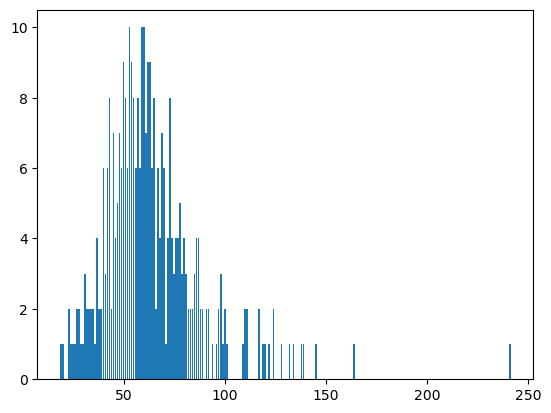

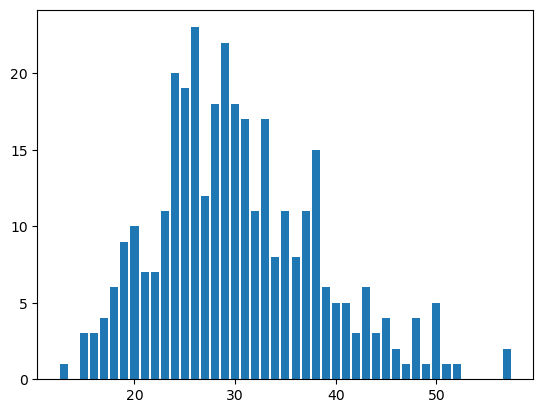

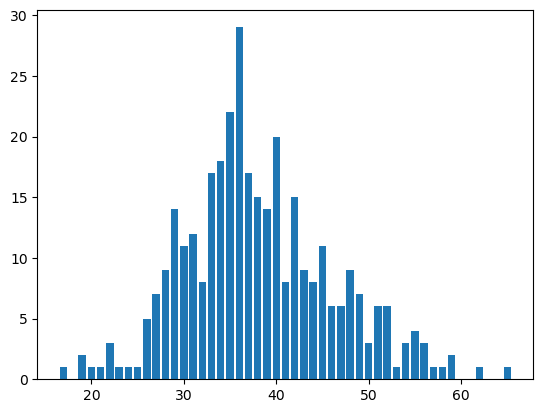

In [9]:
import collections
def draw_from_dict(dicdata,RANGE, heng=0):
    #dicdata：字典的数据。
    #RANGE：截取显示的字典的长度。
    #heng=0，代表条状图的柱子是竖直向上的。heng=1，代表柱子是横向的。考虑到文字是从左到右的，让柱子横向排列更容易观察坐标轴。
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    if heng == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    elif heng == 1:
        plt.barh(x[0:RANGE], y[0:RANGE])
        plt.show()
        return 
    else:
        return "heng的值仅为0或1！"
    
shape_all
a = [list(x) for x in shape_all]
data_z = [x[0] for x in a]
data_x = [x[1] for x in a]
data_y = [x[2] for x in a]

count_dict = collections.Counter(data_z)
draw_from_dict(count_dict,len(data_z),0)

count_dict = collections.Counter(data_x)
draw_from_dict(count_dict,len(data_x),0)

count_dict = collections.Counter(data_y)
draw_from_dict(count_dict,len(data_y),0)

In [3]:
shape_test = [(65, 33, 47), (61, 25, 32), (57, 28, 45), (100, 19, 37), (74, 37, 51), (68, 36, 40), (86, 33, 50), (74, 31, 51), (63, 26, 35), (55, 23, 26), (111, 39, 56), (98, 35, 58), (78, 47, 51), (69, 39, 36), (76, 38, 40), (60, 25, 35), (110, 31, 43), (64, 29, 47), (82, 39, 54), (98, 48, 42), (47, 28, 37), (45, 25, 31), (64, 39, 39), (62, 42, 36), (94, 37, 50), (88, 38, 46), (63, 37, 55), (62, 35, 47), (91, 45, 59), (87, 40, 54), (117, 35, 48), (119, 37, 37), (69, 42, 48), (57, 35, 48), (60, 24, 40), (57, 23, 36), (110, 46, 52), (101, 38, 42), (111, 35, 56), (100, 28, 45), (56, 30, 43), (77, 36, 52), (52, 25, 38), (59, 26, 39), (138, 48, 49), (124, 44, 52), (67, 24, 44), (55, 28, 56), (79, 29, 46), (73, 31, 44), (50, 30, 39), (45, 26, 36), (85, 34, 55), (84, 30, 62), (55, 24, 36), (60, 18, 30), (63, 38, 50), (61, 30, 36), (89, 37, 32), (87, 33, 36), (72, 50, 45), (73, 41, 36), (73, 43, 49), (80, 43, 54), (70, 37, 49), (59, 26, 38), (53, 45, 40), (51, 38, 30), (83, 31, 45), (86, 25, 37), (46, 31, 49), (60, 25, 42), (88, 36, 43), (89, 30, 48), (60, 28, 34), (61, 26, 33), (50, 26, 37), (48, 21, 38), (54, 35, 39), (53, 28, 32), (97, 48, 55), (96, 43, 42), (56, 31, 45), (54, 32, 46), (51, 33, 36), (48, 26, 36), (67, 26, 47), (63, 20, 39), (49, 34, 29), (50, 24, 22), (43, 38, 37), (35, 31, 27), (76, 39, 48), (78, 37, 37), (50, 20, 34), (43, 18, 32), (61, 33, 38), (59, 29, 27), (74, 33, 42), (69, 26, 37), (77, 37, 48), (76, 38, 42), (53, 34, 38), (42, 32, 40), (53, 31, 57), (48, 22, 42), (85, 29, 44), (85, 24, 48), (37, 19, 29), (45, 19, 31), (145, 35, 39), (73, 38, 37), (73, 16, 25), (30, 17, 28), (164, 29, 41), (80, 24, 35), (241, 52, 51), (124, 50, 51), (67, 20, 38), (72, 21, 39), (54, 24, 34), (55, 22, 26), (78, 33, 39), (80, 27, 35), (75, 34, 49), (73, 29, 46), (51, 21, 38), (64, 24, 52), (39, 40, 36), (77, 36, 34), (78, 43, 42), (58, 30, 44), (134, 40, 43), (70, 33, 31), (77, 28, 34), (69, 25, 38), (57, 50, 35), (109, 50, 55), (40, 27, 36), (40, 21, 33), (68, 28, 36), (34, 28, 43), (62, 32, 38), (132, 30, 36), (66, 29, 40), (128, 28, 32), (53, 28, 37), (50, 26, 35), (53, 26, 42), (42, 28, 38), (43, 35, 42), (32, 23, 33), (53, 28, 41), (46, 29, 40), (91, 33, 45), (92, 26, 48), (65, 29, 43), (58, 23, 34), (70, 32, 38), (72, 27, 43), (43, 29, 33), (86, 29, 33), (64, 26, 36), (69, 31, 36), (62, 32, 34), (65, 32, 28), (50, 30, 37), (50, 24, 33), (56, 51, 42), (52, 48, 36), (69, 37, 40), (60, 31, 35), (58, 30, 49), (63, 27, 41), (63, 34, 37), (65, 32, 35), (38, 24, 34), (67, 32, 40), (47, 31, 32), (48, 29, 28), (31, 18, 30), (31, 17, 32), (82, 57, 52), (87, 57, 46), (35, 26, 19), (34, 20, 20), (79, 27, 40), (78, 25, 35), (86, 44, 53), (80, 34, 46), (65, 33, 40), (59, 28, 45), (54, 27, 43), (54, 24, 29), (63, 23, 35), (67, 20, 34), (83, 25, 37), (74, 27, 44), (81, 45, 42), (79, 41, 49), (71, 30, 31), (70, 23, 33), (49, 29, 36), (51, 30, 31), (62, 38, 34), (61, 38, 34), (54, 41, 36), (68, 40, 26), (40, 36, 40), (42, 32, 35), (54, 33, 34), (54, 26, 36), (41, 30, 29), (37, 34, 31), (52, 26, 37), (57, 18, 29), (33, 18, 35), (33, 13, 34), (60, 50, 45), (60, 49, 42), (25, 29, 30), (24, 27, 36), (28, 26, 19), (27, 25, 17), (50, 35, 38), (43, 41, 34), (50, 28, 33), (55, 25, 35), (52, 22, 28), (46, 20, 31), (122, 44, 51), (120, 26, 40), (72, 33, 36), (65, 27, 30), (55, 30, 40), (51, 22, 38), (66, 25, 36), (58, 19, 30), (63, 21, 37), (65, 30, 33), (59, 28, 35), (62, 29, 31), (57, 38, 39), (55, 31, 27), (75, 36, 48), (73, 33, 27), (59, 31, 44), (60, 24, 40), (76, 28, 47), (69, 22, 36), (29, 26, 23), (28, 25, 22), (20, 19, 40), (19, 15, 30), (92, 45, 41), (84, 43, 28), (81, 26, 37), (81, 25, 35), (45, 32, 33), (47, 29, 40), (61, 39, 33), (65, 29, 24), (56, 26, 29), (49, 23, 42), (48, 19, 29), (49, 15, 27), (44, 25, 39), (39, 25, 35), (58, 27, 40), (57, 24, 34), (48, 24, 34), (43, 17, 31), (31, 20, 21), (32, 21, 30), (55, 17, 30), (53, 16, 32), (59, 33, 45), (59, 37, 52), (59, 24, 44), (58, 18, 34), (37, 20, 28), (38, 21, 36), (51, 24, 41), (51, 20, 27), (53, 22, 31), (43, 22, 26), (63, 29, 40), (62, 27, 35), (56, 24, 41), (53, 29, 39), (26, 25, 29), (23, 24, 27), (45, 23, 33), (49, 15, 33), (43, 26, 41), (41, 16, 29), (47, 38, 45), (56, 30, 33), (47, 27, 35), (45, 23, 28), (98, 34, 47), (97, 28, 36), (62, 40, 37), (67, 36, 42), (57, 30, 38), (51, 35, 36), (87, 30, 44), (99, 29, 33), (52, 35, 35), (59, 33, 33), (46, 46, 65), (40, 30, 59), (48, 31, 29), (49, 31, 29), (36, 33, 38), (37, 29, 29), (45, 37, 31), (42, 38, 40), (64, 38, 41), (61, 31, 39), (23, 19, 26), (27, 20, 29), (75, 36, 28), (73, 29, 22), (52, 26, 36), (54, 23, 30), (40, 24, 29), (41, 25, 30), (117, 19, 31), (60, 19, 35), (42, 31, 36), (42, 23, 35), (139, 33, 28), (70, 43, 34), (70, 42, 43), (68, 41, 39), (64, 25, 45), (62, 24, 33), (40, 32, 35), (44, 38, 39)]
c = [list(x) for x in shape_test]
cc = [x for x in c if x[0]>128 or x[1]>64 or x[2]>64]
cc

[[138, 48, 49],
 [145, 35, 39],
 [164, 29, 41],
 [241, 52, 51],
 [134, 40, 43],
 [132, 30, 36],
 [46, 46, 65],
 [139, 33, 28]]

In [10]:
""" print("-------------------------分割Z-------------------------------") #（Z，X, Y）
z = np.any(seg_array, axis=(1, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
start_slice, end_slice = np.where(z)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
print(start_slice , end_slice)
seg_array1 = seg_array[start_slice:end_slice + 1, :, :]
print(seg_array1.shape)

print("-------------------------分割X-------------------------------") #（Z，X, Y）
x = np.any(seg_array, axis=(0, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
start_slice, end_slice = np.where(x)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
print(start_slice , end_slice)
seg_array1 = seg_array1[:,start_slice:end_slice + 1,:]
print(seg_array1.shape) 
                            
print("-------------------------分割y-------------------------------") #（Z，X, Y）
y = np.any(seg_array, axis=(0, 1))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
start_slice, end_slice = np.where(y)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
print(start_slice , end_slice)
seg_array1 = seg_array1[: , :, start_slice:end_slice + 1]

print(seg_array.shape)
print(seg_array1.shape)
plt.subplot(131)
plt.imshow(seg_array[307,:,:])
plt.subplot(132)
plt.imshow(seg_array1[20,:,:])
plt.subplot(133)
plt.imshow(pix_resampled[20,:,:],plt.cm.gray)
plt.show() """



' print("-------------------------分割Z-------------------------------") #（Z，X, Y）\nz = np.any(seg_array, axis=(1, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True\nstart_slice, end_slice = np.where(z)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个\nprint(start_slice , end_slice)\nseg_array1 = seg_array[start_slice:end_slice + 1, :, :]\nprint(seg_array1.shape)\n\nprint("-------------------------分割X-------------------------------") #（Z，X, Y）\nx = np.any(seg_array, axis=(0, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True\nstart_slice, end_slice = np.where(x)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个\nprint(start_slice , end_slice)\nseg_array1 = seg_array1[:,start_slice:end_slice + 1,:]\nprint(seg_array1.shape) \n                            \nprint("-------------------------分割y-------------------------------") #（Z，X, Y）\ny = np.any(seg_array, axis=(0, 1))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True\nstart_slice, end_slice = np.where(y)[0][[0, -1]] #np.where返回为True的数组下标，[[

In [11]:
""" ##################################可视化
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces ,normals, values= measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

plot_3d(pix_resampled, 400) """

" ##################################可视化\nfrom skimage import measure, morphology\nfrom mpl_toolkits.mplot3d.art3d import Poly3DCollection\ndef plot_3d(image, threshold=-300):\n    \n    # Position the scan upright, \n    # so the head of the patient would be at the top facing the camera\n    p = image.transpose(2,1,0)\n    \n    verts, faces ,normals, values= measure.marching_cubes(p, threshold)\n    fig = plt.figure(figsize=(10, 10))\n    ax = fig.add_subplot(111, projection='3d')\n\n    # Fancy indexing: `verts[faces]` to generate a collection of triangles\n    mesh = Poly3DCollection(verts[faces], alpha=0.70)\n    face_color = [0.45, 0.45, 0.75]\n    mesh.set_facecolor(face_color)\n    ax.add_collection3d(mesh)\n\n    ax.set_xlim(0, p.shape[0])\n    ax.set_ylim(0, p.shape[1])\n    ax.set_zlim(0, p.shape[2])\n\n    plt.show()\n\nplot_3d(pix_resampled, 400) "

下面正式开始分割代码

In [19]:
def sup_128(xmin, xmax, max_slice):  #返回z轴切片范围
    if xmax - xmin < 128:
        ecart = int((128 - (xmax - xmin)) / 2)
        if (xmax - xmin) % 2 ==  0:
            xmax = xmax + ecart
        else:
            xmax = xmax + ecart + 1
        xmin = xmin - ecart
    elif xmax - xmin >128:
        ecart = int((xmin + xmax)/2)
        xmax = ecart + 64
        xmin = ecart - 64
    if xmin < 0:
        xmax -= xmin
        xmin = 0
    if xmax > max_slice:
        xmin = xmin - (xmax - max_slice)
        xmax = max_slice
    #print(xmax,xmin)
    assert abs(xmin - xmax) == 128 , "切片数目不是128"
    return xmin, xmax

def sup_64(xmin, xmax, max_slice):  #返回xy轴的切片范围
    if xmax - xmin < 64:
        ecart = int((64 - (xmax - xmin)) / 2)
        if (xmax - xmin) % 2 ==  0:
            xmax = xmax + ecart
        else:
            xmax = xmax + ecart + 1
        xmin = xmin - ecart
    elif xmax - xmin >64:
        ecart = int((xmin + xmax)/2)
        xmax = ecart + 32
        xmin = ecart - 32
    if xmin < 0:
        xmax -= xmin
        xmin = 0
    if xmax > max_slice:
        xmin = xmin - (xmax - max_slice)
        xmax = max_slice
    #print(xmax,xmin)
    assert abs(xmin - xmax) == 64 , "切片数目不是64"
    return xmin, xmax


In [24]:
def fix_and_save(path,index,ct_file_name,mode="pre"):
    seg_path_pre = [word for word  in os.listdir(path[0]) if '_T.nii' in word]
    print(path)
    seg_path_pre = os.path.join(path[0],seg_path_pre[0])
    print(seg_path_pre)
    first_patient = load_scan(path)
    first_patient_pixels = get_pixels_hu(first_patient)

    seg = sitk.ReadImage(seg_path_pre, sitk.sitkInt8)
    seg_array = sitk.GetArrayFromImage(seg)

    pix_resampled, spacing, seg_resize = resample(first_patient_pixels, first_patient, [1,1,1])
    seg_array = ndimage.zoom(seg_array, seg_resize,order=0)

    z = np.any(seg_array, axis=(1, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
    x = np.any(seg_array, axis=(0, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
    y = np.any(seg_array, axis=(0, 1))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True

    z_start, z_end = np.where(z)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
    z_start, z_end = sup_128(z_start, z_end, seg_array.shape[0]-1)
    x_start, x_end = np.where(x)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一
    x_start, x_end = sup_64(x_start, x_end, seg_array.shape[1]-1)
    y_start, y_end = np.where(y)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
    y_start, y_end = sup_64(y_start, y_end, seg_array.shape[2]-1)

    pix_resampled = pix_resampled[z_start:z_end, x_start:x_end, y_start:y_end]  #ct
    seg_array = seg_array[z_start:z_end, x_start:x_end, y_start:y_end]          #segmentation

    new_ct = sitk.GetImageFromArray(pix_resampled)
    new_ct.SetDirection(seg.GetDirection())
    new_ct.SetOrigin(seg.GetOrigin())
    new_ct.SetSpacing([1,1,1])
            
    new_seg = sitk.GetImageFromArray(seg_array)
    new_seg.SetDirection(seg.GetDirection())
    new_seg.SetOrigin(seg.GetOrigin())
    new_seg.SetSpacing([1,1,1])

    if mode == "pre":
        ct_file_name = "./pre/ct/volume-{}.nii".format(index)
    elif mode =="post":
        ct_file_name = "./post/ct/volume-{}.nii".format(index)
    #ct_file = "volume-{}".format(index)
    if new_ct != None and new_seg != None:
        sitk.WriteImage(new_ct, ct_file_name)
        sitk.WriteImage(new_seg, ct_file_name.replace('volume', 'segmentation').replace('ct','seg'))


In [25]:
data_path_SZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou"
data_path_ZZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong"
pre_save_path = "./pre"
post_save_path = "./post"
count = 1
for data_path in range(2):
    if data_path == 0:
        t1_path, t2_path = SZ_data_path(data_path_SZ)
    elif data_path == 1:
        t1_path, t2_path = ZZ_data_path(data_path_ZZ)
    for i in range(len(t1_path)):
        pre_path = t1_path[i]
        post_path = t2_path[i]
        fix_and_save(pre_path,count,pre_save_path,"pre")
        fix_and_save(post_path,count,post_save_path,"post")
        count += 1
    if data_path == 0:
        print("SZ 数据有{}个".format(count-1))
print("共有数据{}个".format(count-1))

['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou\\SZ1\\202006~2CT\\00000006A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\shantou\SZ1\202006~2CT\00000006A\SZ1_20200626A_T.nii.gz
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou\\SZ1\\202009~2CT\\000001F6A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\shantou\SZ1\202009~2CT\000001F6A\SZ1_20200916A_T.nii.gz
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou\\SZ2\\202006~2CT\\000001F6A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\shantou\SZ2\202006~2CT\000001F6A\SZ2_20200624A_T.nii.gz
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou\\SZ2\\202009~3CT\\00000004A5']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\shantou\SZ2\202009~3CT\00000004A5\SZ2_20200909A_T.nii.gz
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou\\SZ3\\202005~2CT\\000001F6A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\shantou\SZ3\202005~2CT\000001F6A\SZ3_20200506A_T.nii.gz
['E:\\BaiduNetdisk

e:\anaconda\envs\pytorch_gpu\lib\site-packages\pydicom\charset.py:754: UserWarning: Unknown encoding 'ISO 2022 IR 165' - using default encoding instead
  _warn_about_invalid_encoding(encoding)


['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong\\ZZ14\\20171025\\SRS00007A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\zhongzhong\ZZ14\20171025\SRS00007A\ZZ14_20171025A_T.nii.gz
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong\\ZZ15\\20170719\\SRS00010A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\zhongzhong\ZZ15\20170719\SRS00010A\ZZ15_20170719A_T.nii.gz
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong\\ZZ15\\20171010\\SRS00004A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\zhongzhong\ZZ15\20171010\SRS00004A\ZZ15_20171010A_T.nii.gz
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong\\ZZ16\\20170708\\SRS00006A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\zhongzhong\ZZ16\20170708\SRS00006A\ZZ16_20170708A_T.nii.gz
['E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong\\ZZ16\\20171010\\SRS00003A']
E:\BaiduNetdiskDownload\shiguanai\shiguanai-pcr\zhongzhong\ZZ16\20171010\SRS00003A\ZZ16_20171010A_T.ni

把文件名啥的都写入文件中

In [13]:
def pCR_or_not(index):
    if index > 55 :
        data = pd.read_csv('./zhongzhong_info.csv',encoding = 'utf-8')
        #print(data.loc[index-56,'ID'],data.loc[index-56,'No'],data.loc[index-56,'pCR'])
        pcr = data.loc[index-56,'pCR']
    else:
        data = pd.read_csv('./shantou_info.csv', encoding='utf-8')
        #print(data.loc[index-1,'ID'],data.loc[index-1,'No'],data.loc[index-1,'pCR'])
        pcr = data.loc[index-1,'pCR']

    #print(data.loc[index-1,'ID'],data.loc[index-1,'No'],data.loc[index-1,'pCR'])
    return pcr

""" for i in range(10):
    pcr = pCR_or_not(56+i)
    print(pcr)
     """

' for i in range(10):\n    pcr = pCR_or_not(56+i)\n    print(pcr)\n     '

In [14]:
import random
def write_train_val_name_list(valid_rate):
    data_name_list = os.listdir("./pre/ct/")
    data_num = len(data_name_list)
    print('the single dataset total numbers of samples is :', data_num)
    random.shuffle(data_name_list)

    assert valid_rate < 1.0 #验证集比率0.2
    train_name_list = data_name_list[0:int(data_num*(1-valid_rate))]
    print("train data length : ",len(train_name_list))
    val_name_list = data_name_list[int(data_num*(1-valid_rate)):int(data_num*((1-valid_rate) + valid_rate))]
    print("val data length :",len(val_name_list))

    print(train_name_list)
    write_name_list(train_name_list, "train_path_list.txt")
    write_name_list(val_name_list, "val_path_list.txt")


def write_name_list(name_list, file_name):
    f = open(file_name, 'w')
    for name in name_list:
        index = int(re.split('-|.nii',name)[1])
        pcr = pCR_or_not(index)
        print(index,pcr)
        pre_ct_path = os.path.join('./pre', 'ct', name)
        post_ct_path = os.path.join('./post', 'ct', name)
        f.write(pre_ct_path + ' ' + post_ct_path + ' ' + str(pcr) + "\n")
    f.close()

write_train_val_name_list(0.2)

the single dataset total numbers of samples is : 170
train data length :  136
val data length : 34
['volume-98.nii', 'volume-141.nii', 'volume-88.nii', 'volume-60.nii', 'volume-69.nii', 'volume-93.nii', 'volume-138.nii', 'volume-4.nii', 'volume-95.nii', 'volume-39.nii', 'volume-11.nii', 'volume-24.nii', 'volume-78.nii', 'volume-125.nii', 'volume-57.nii', 'volume-46.nii', 'volume-40.nii', 'volume-102.nii', 'volume-112.nii', 'volume-94.nii', 'volume-142.nii', 'volume-90.nii', 'volume-44.nii', 'volume-43.nii', 'volume-37.nii', 'volume-13.nii', 'volume-38.nii', 'volume-66.nii', 'volume-86.nii', 'volume-116.nii', 'volume-107.nii', 'volume-159.nii', 'volume-21.nii', 'volume-70.nii', 'volume-12.nii', 'volume-27.nii', 'volume-136.nii', 'volume-28.nii', 'volume-82.nii', 'volume-67.nii', 'volume-64.nii', 'volume-166.nii', 'volume-130.nii', 'volume-114.nii', 'volume-50.nii', 'volume-111.nii', 'volume-79.nii', 'volume-1.nii', 'volume-92.nii', 'volume-77.nii', 'volume-100.nii', 'volume-32.nii', 'vo

In [ ]:
""" data_path_SZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\shantou"
data_path_ZZ = "E:\\BaiduNetdiskDownload\\shiguanai\\shiguanai-pcr\\zhongzhong"

i=5
t1_path, t2_path = SZ_data_path(data_path_SZ)
pre_path = t1_path[i]
post_path = t2_path[i]
seg_path_pre = [word for word  in os.listdir(pre_path[0]) if '_T.nii.gz' in word]
print(pre_path)
seg_path_pre = os.path.join(pre_path[0],seg_path_pre[0])
print(seg_path_pre)
first_patient = load_scan(pre_path)
first_patient_pixels = get_pixels_hu(first_patient)

seg = sitk.ReadImage(seg_path_pre, sitk.sitkInt8)
seg_array = sitk.GetArrayFromImage(seg)

pix_resampled, spacing, seg_resize = resample(first_patient_pixels, first_patient, [1,1,1])
seg_array = ndimage.zoom(seg_array, seg_resize,order=0)

z = np.any(seg_array, axis=(1, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
x = np.any(seg_array, axis=(0, 2))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True
y = np.any(seg_array, axis=(0, 1))  #axis=(1,2)是xy轴,在xy轴上进行，如果有数，则其所在的z轴就返回True

z_start, z_end = np.where(z)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
z_start, z_end = sup_128(z_start, z_end, seg_array.shape[0]-1)
x_start, x_end = np.where(x)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一
x_start, x_end = sup_64(x_start, x_end, seg_array.shape[1]-1)
y_start, y_end = np.where(y)[0][[0, -1]] #np.where返回为True的数组下标，[[0,-1]]读出第一个和最后一个
y_start, y_end = sup_64(y_start, y_end, seg_array.shape[2]-1)

pix_resampled = pix_resampled[z_start:z_end, x_start:x_end, y_start:y_end]  #ct
seg_array = seg_array[z_start:z_end, x_start:x_end, y_start:y_end]          #segmentation

new_ct = sitk.GetImageFromArray(pix_resampled)
new_ct.SetDirection(seg.GetDirection())
new_ct.SetOrigin(seg.GetOrigin())
new_ct.SetSpacing([1,1,1])
        
new_seg = sitk.GetImageFromArray(seg_array)
new_seg.SetDirection(seg.GetDirection())
new_seg.SetOrigin(seg.GetOrigin())
new_seg.SetSpacing([1,1,1])

ct_file_name = "./pre/volume-{}.nii".format(i)
if new_ct != None and new_seg != None:
    sitk.WriteImage(new_ct, ct_file_name)
    sitk.WriteImage(new_seg, ct_file_name.replace('volume', 'segmentation'))
 """